# No priority

Average waiting time is: 101.69549793700509
With the Confidence Interval:  97.72134611166709 105.66964976234308
Confidence Interval's Size:  7.948303650675996
Average job's size is: 1.984243900101865
With the Confidence Interval:  1.9473462091600224 2.0211415910437074
Confidence Interval's Size:  0.07379538188368495


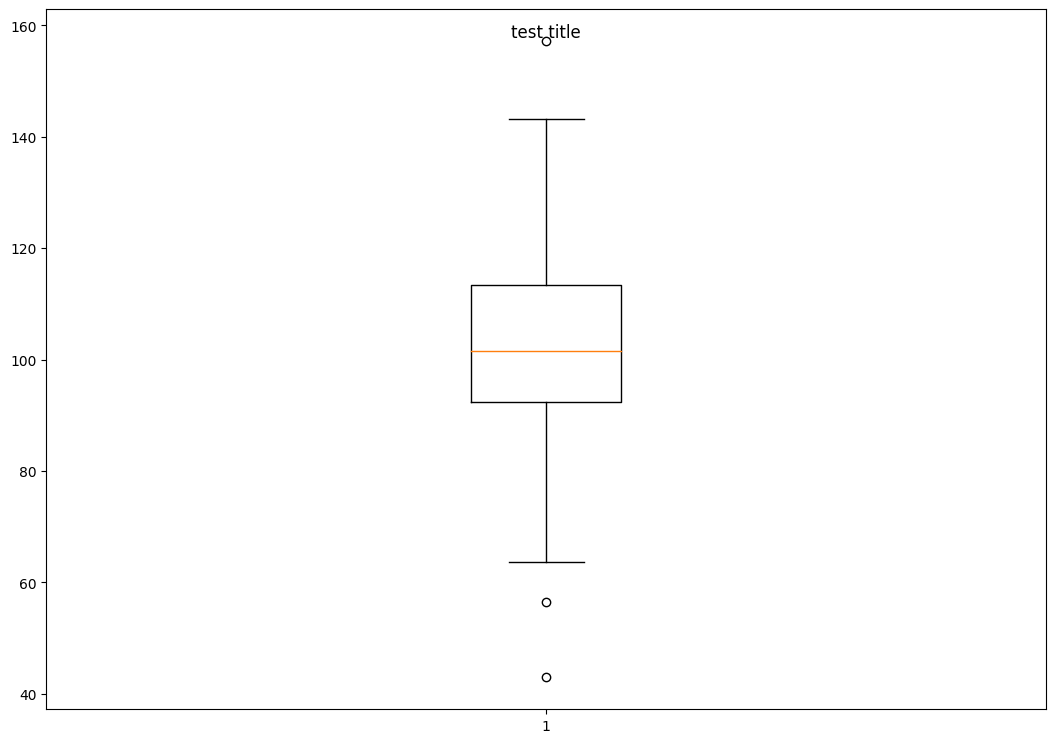

In [23]:
import simpy
import numpy as np

# Confidence Interval calculation
from scipy.stats import t
def confidence_interval(simulation_results, title="", confidence=0.95, output_results=True):
    mean = np.mean(simulation_results)
    std = np.std(simulation_results)
    degree = len(simulation_results) - 1 
    t_crit = np.abs(t.ppf((1-confidence)/2, degree))    # Find the inverse cumulative distribution.
    ci = std*t_crit/np.sqrt(len(simulation_results))
    if output_results:
        print(str(title) + str(mean))
        conf_int_low = mean-ci
        conf_int_high = mean+ci
        print("With the Confidence Interval: ", conf_int_low, conf_int_high)
        print("Confidence Interval's Size: ", conf_int_high-conf_int_low)
        return
    else: return mean, ci

jobs_to_process = 300   # Max number of customers
runtime_limit = 400.0   # Runtime limit
seed = 42               # Seed for simulation

# miu
job_rate = 1.0   # Mean time in bank
# lambda
arrival_rate = 1.0  # Mean of arrival process
# n
servers_amount = 1

priority_queue = False
job_distribution = "Exponential_Fat"    # "Exponential", "Exponential_Fat", "Degenerate"


def Customer(env, name, resources):
    arrive = env.now

    # Getting Status of Queues
    queue_size = []
    for queue in resources:
        queue_size.append(len(queue.put_queue) + len(queue.users))

    # Choosing a Queue for an arrived Client
    choice = np.argmin(queue_size)
    
    # Deciding on job size
    if job_distribution=="Exponential":
        job_duration = np.random.exponential(job_rate)
    if job_distribution=="Exponential_Fat":
        if np.random.uniform() < 0.75:
            job_duration = np.random.exponential(job_rate)
        else:
            job_duration = np.random.exponential(5*job_rate)
    if job_distribution=="Degenerate":
            job_duration = job_rate

    job_durations.append(job_duration)
    # Handling depends on the chosen queue
    if priority_queue:
        # Sending job to its position
        with resources[choice].request(priority=job_duration) as req:
            # Wait for the Server
            yield req
            waiting_times.append(env.now - arrive)
            # Starting the Job
            yield env.timeout(job_duration)
    else:
        with resources[choice].request() as req:
            # Wait for the Server
            yield req
            waiting_times.append(env.now - arrive)
            # Starting the Job
            yield env.timeout(job_duration)
  
def Source(env, jobs_to_process, arrival_rate, resources):
    for i in range(jobs_to_process):
        c = Customer(env, 'Customer ' + str(i), resources)
        env.process(c)
        t = np.random.exponential(arrival_rate)
        yield env.timeout(t)


# Starting Simulation
trials = 100
np.random.seed(seed)
waiting_times_trials = []
job_durations_trials = []
for i in range(trials):
    waiting_times = []      # Waiting times of performed jobs
    job_durations = []      # Average job size
    # Setup trial
    env = simpy.Environment()
    # Creating Queues
    resources = []
    if priority_queue:
        for n in range (servers_amount):
            resources.append(simpy.PriorityResource(env))
    else:
        for n in range (servers_amount):
            resources.append(simpy.Resource(env))
    env.process(Source(env, jobs_to_process, arrival_rate, resources))
    env.run(until=runtime_limit)

    waiting_times_trials.append(np.mean(waiting_times))     # Saving Results
    job_durations_trials.append(np.mean(job_durations))     # Saving Results

confidence_interval(waiting_times_trials, "Average waiting time is: ")
confidence_interval(job_durations_trials, "Average job's size is: ")    # Just to verify that right distribution is used



# Visualization
import matplotlib.pyplot as plt

data = [waiting_times_trials]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

plt.show()